<a href="https://colab.research.google.com/github/whiteevl/machine-learning/blob/main/Second_Project_Creating_a_Machine_Learning_Model_with_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
nama = "Aradea Bayu Murti"
email = "whiteevilfero@gmail.com"
no_hp = "62857****47643"
id_dicoding = "priceofdarkness"
link_dataset = "https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset"

print(f'Nama: {nama}')
print(f'Email: {email}')
print(f'No. HP: {no_hp}')
print(f'ID Dicoding: {id_dicoding}')
print(f'Dataset: {link_dataset}')

Nama: Aradea Bayu Murti
Email: whiteevilfero@gmail.com
No. HP: 62857****47643
ID Dicoding: priceofdarkness
Dataset: https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset


In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
import matplotlib.pyplot as plt

In [ ]:
london_data = pd.read_csv('london_merged.csv', encoding= 'unicode_escape')
london_data

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [ ]:
london_data.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [ ]:
london_data.shape

(17414, 10)

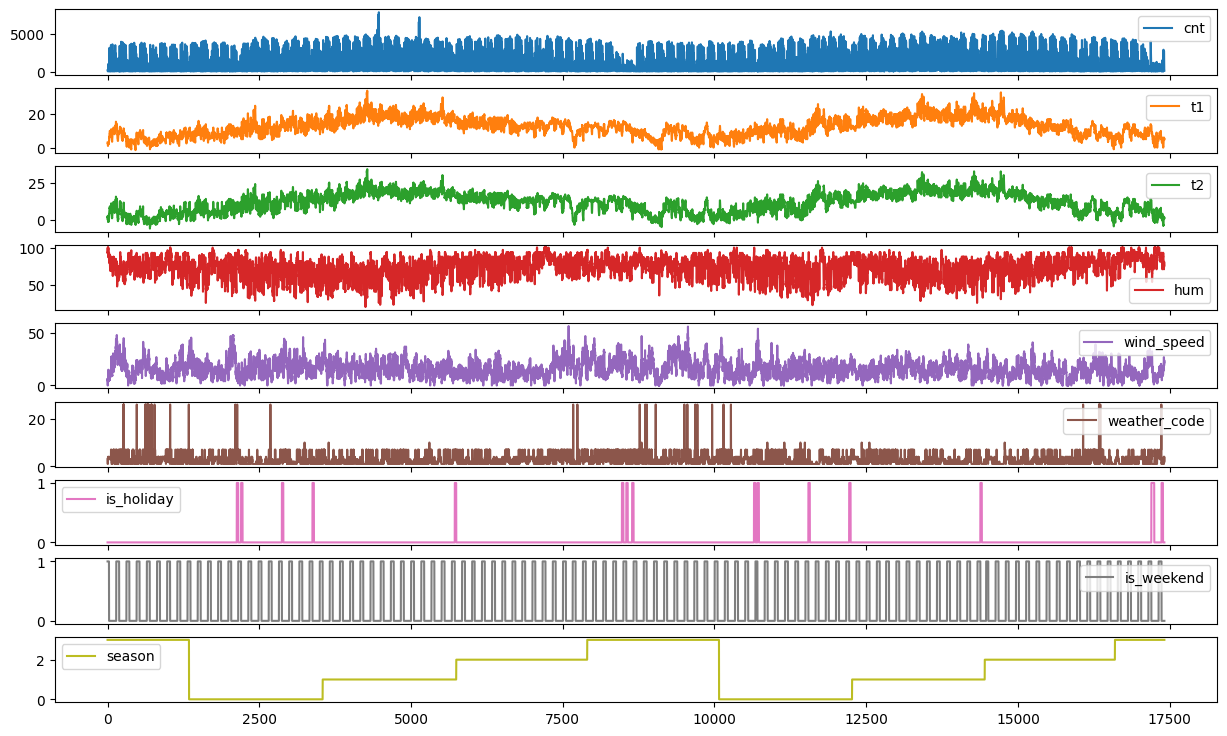

In [ ]:
df_plot = london_data
df_plot[df_plot.columns.to_list()].plot(subplots=True, figsize=(15, 9))
plt.show()

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

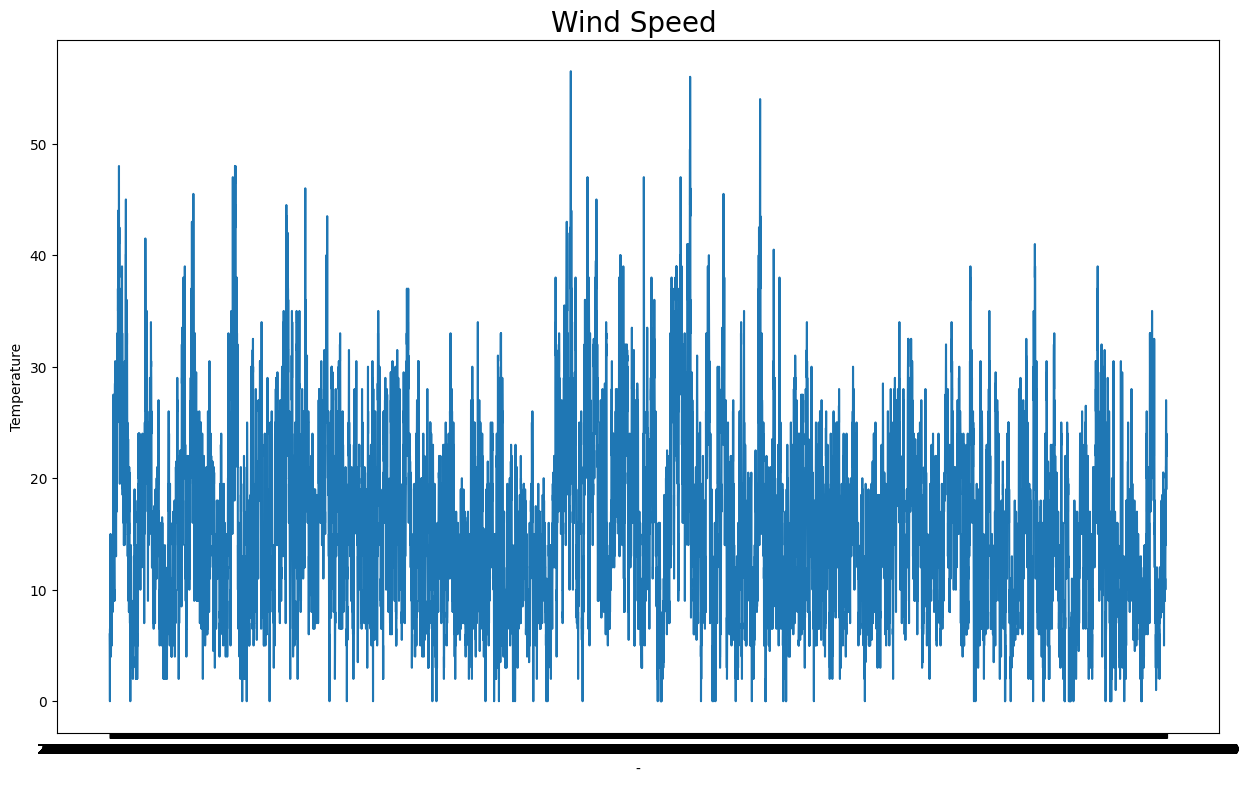

In [ ]:
dates = london_data['timestamp'].values
wind = london_data['wind_speed'].values

dates = np.array(dates)
wind = np.array(wind)

plt.figure(figsize=(15,9))
plt.plot(dates, wind)

plt.title('Wind Speed ', fontsize = 20)
plt.ylabel('Temperature')
plt.xlabel('-')

london_data.dtypes

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(wind, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [ ]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  13931
Total Data Validation :  3483


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
tf.keras.backend.set_floatx('float64')


train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(30, return_sequences=True,  input_shape=[None, 1]),
  tf.keras.layers.LSTM(30),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
minMae = (london_data['wind_speed'].max() - london_data['wind_speed'].min()) * 10/100
print(minMae)

5.65


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<minMae) & (logs.get('val_mae')<minMae):
      print('\nMAE sudah mencapai <10%!')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
    )
history = model.fit(
    train_set,
    epochs=200,
    validation_data=val_set,
    verbose=2,
    callbacks=[callbacks],
    )

Epoch 1/200
139/139 - 33s - loss: 15.5578 - mae: 16.0572 - val_loss: 12.1252 - val_mae: 12.6248 - 33s/epoch - 235ms/step
Epoch 2/200
139/139 - 26s - loss: 14.2747 - mae: 14.7735 - val_loss: 10.1883 - val_mae: 10.6834 - 26s/epoch - 191ms/step
Epoch 3/200
139/139 - 28s - loss: 10.2923 - mae: 10.7837 - val_loss: 5.2001 - val_mae: 5.6799 - 28s/epoch - 204ms/step
Epoch 4/200
139/139 - 28s - loss: 5.8300 - mae: 6.3131 - val_loss: 5.2451 - val_mae: 5.7316 - 28s/epoch - 198ms/step
Epoch 5/200
139/139 - 26s - loss: 5.4795 - mae: 5.9617 - val_loss: 4.6852 - val_mae: 5.1675 - 26s/epoch - 190ms/step
Epoch 6/200

MAE sudah mencapai <10%!
139/139 - 28s - loss: 4.7656 - mae: 5.2441 - val_loss: 3.6292 - val_mae: 4.1042 - 28s/epoch - 204ms/step


In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

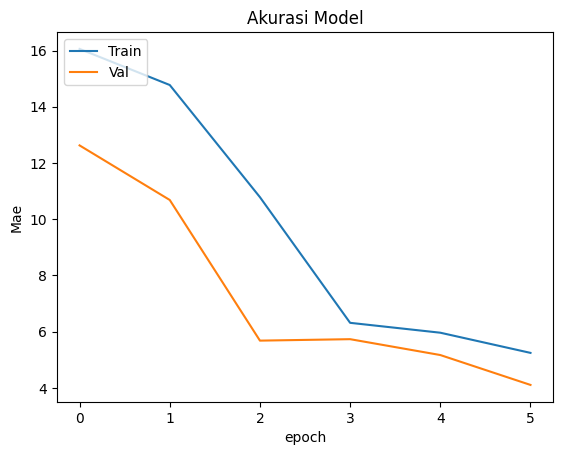

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

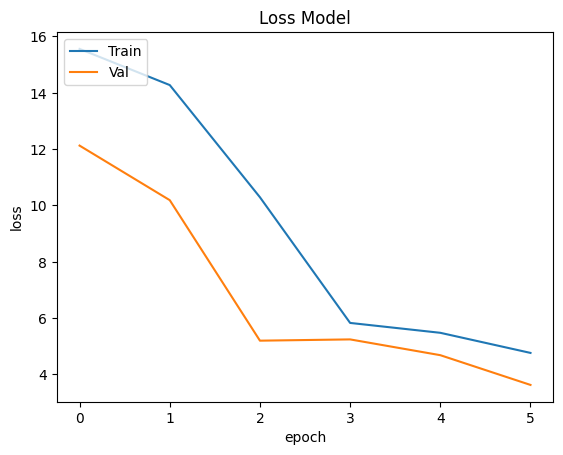

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()